# CS 4820
# Tutorial 10: MNIST - Convolutional Neural Network

### Architecture

In Tutorial 7, we treated pixels as features and used a fully-connected neural network to classify the images in the MNIST dataset.

![Fully connected network to solve MNIST](./assets/mnist_fc.png)

In this Tutorial, we are going to 

- Convolve the images using convolutional, pooling and activation layers that are stacked together, feeding the output of one layer into the input of the next. This stacking results in a feature-extraction pipeline that will gradually transform an image into a tensor with more channels and fewer pixels:

![Convolutional stack](./assets/conv_stack.png)

    The value of each "pixel" in the last feature map is influenced by a large regions of the original image and it will have learned to recognize complex patterns.
    
   > That's the beauty of stacking convolutional layers. The first layers will learn patterns of pixels in the original image, while deeper layers will learn more complex patterns that are combinations of the simpler patterns. 
   > 
   > In practice, early layers will specialize to recognize contrast lines in different orientations, while deeper layers will combine those contrast lines to identify parts of objects. The typical example of this is the face recognition task where middle layers recognize facial features like eyes, noses, and mouths while deeper nodes specialize on individual faces.
   > 
   > The convolutional stack behaves like an optimized feature extraction pipeline that is trained to solve the task at hand optimally.

- To complete the pipeline and solve the classification task we can pipe the output of the feature extraction pipeline into a fully connected final stack of layers.

    We will need to unroll the output tensor into a long vector (as we did initially for the MNIST data) and connect this vector to the labels using a fully connected network.
    
    ![Flatten layer](./assets/flatten_fc.png)

    We can also stack multiple fully connected layers if we want. Our final network is like a pancake of many layers, the convolutional part dealing with feature extraction and the fully connected part handling the classification.

    The deeper we go in the network the richer and more unique are the patterns matched and so more robust the classification will be.

### Preparing images

Let's load the data in first.

In [1]:
from tensorflow.keras.datasets import mnist

# allow multiple outputs be displayed for each cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape
y_train.shape
X_test.shape
y_test.shape

(60000, 28, 28)

(60000,)

(10000, 28, 28)

(10000,)

In [3]:
X_train_sc = X_train.astype('float32') / 255.0
X_test_sc = X_test.astype('float32') / 255.0

As you all now, we need to reshape the data as order-4 tensors. 

In [4]:
X_train_t = X_train_sc.reshape(-1, 28, 28, 1)
X_test_t = X_test_sc.reshape(-1, 28, 28, 1)

X_train_t.shape
X_test_t.shape

(60000, 28, 28, 1)

(10000, 28, 28, 1)

Like in Tutorial 7, we also need to one-hot encode the multiclass output.

In [5]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


y_train_cat.shape
y_test_cat.shape

(60000, 10)

(10000, 10)

### Convolutional network on images

Let's now build a simple model with the following architecture:

- A `Conv2D` layer with 32 filters of size 3x3.
- A `MaxPooling2D` layer of size 2x2.
- An activation layer with a `ReLU` activation function.
- A couple of fully connected layers leading to the output of 10 classes corresponding to the digits.

Notice that between the convolutional layers and the fully connected layers we will need `Flatten` to reshape the feature maps into feature vectors.

To speed up the convergence, we initialize the convolutional weights drawing from a random normal distribution.

Also notice that we need to pass `input_shape=(28, 28, 1)` to let the model know our input images are grayscale 28x28 images:

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense

from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten, Activation

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1),
                 kernel_initializer='normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
activation (Activation)      (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                346176    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 347,146
Trainable params: 347,146
Non-trainable params: 0
__________________________________________________

__Q: Why `Param # = 0` on the `max_pooling2d`, `activation`, and `flatten` layers?__

__A:__ 

Because weights on these layers are all fixed instead of trained.

__Q: Why `Output Shape = (None, 5408)` on the flatten layer?__

__A:__ 

$5408 = 13*13*32$

__Q: Why `Param # = 346176` in `dense` layer?__

__A:__ 

$346176 = 5408*64+64$

__Q: Why `Param # = 650` in `dense_1` layer?__

__A:__ 

$650 = 64*10+10$


This model has 300k parameters, that's almost half of the fully connected model we designed in Tutorial 7. Let's train it for five epochs. Notice that we pass the tensor data we created above:

In [7]:
h = model.fit(X_train_t, y_train_cat, batch_size=128,
              epochs=5, verbose=1, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 24s 441us/sample - loss: 0.3196 - accuracy: 0.9068 - val_loss: 0.1046 - val_accuracy: 0.9727
Epoch 2/5
54000/54000 [==============================] - 23s 432us/sample - loss: 0.0970 - accuracy: 0.9715 - val_loss: 0.0624 - val_accuracy: 0.9830
Epoch 3/5
54000/54000 [==============================] - 24s 452us/sample - loss: 0.0613 - accuracy: 0.9818 - val_loss: 0.0553 - val_accuracy: 0.9848
Epoch 4/5
54000/54000 [==============================] - 24s 440us/sample - loss: 0.0460 - accuracy: 0.9863 - val_loss: 0.0533 - val_accuracy: 0.9840
Epoch 5/5
54000/54000 [==============================] - 24s 450us/sample - loss: 0.0361 - accuracy: 0.9893 - val_loss: 0.0554 - val_accuracy: 0.9862


Like in Tutorial 7, we can display the training history:

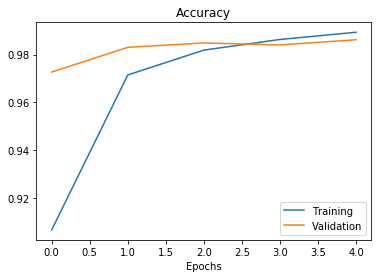

In [9]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epochs')

In [10]:
train_acc = model.evaluate(X_train_t, y_train_cat,
                           verbose=0)[1]
test_acc = model.evaluate(X_test_t, y_test_cat,
                          verbose=0)[1]

print("Train accuracy: {:0.4f}".format(train_acc))
print("Test accuracy: {:0.4f}".format(test_acc))

Train accuracy: 0.9910
Test accuracy: 0.9831


The convolutional model achieved a better performance on the MNIST data in fewer epochs. Overfitting also decreases, because the model is learning to combine spatial patterns instead of learning the exact values of the pixels.